# Trabalho Prático 2 - Introdução à Computação Visual 

### Isadora Cristina

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import OpenGL.GLU as glu
import OpenGL.GL as gl
import OpenGL.GLUT as glut
import cv2
from objloader import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 1. Calibração da câmera

In [2]:
# A calibração da câmera foi feita pelo Matlab 
# De forma semelhante à atividade prática, foi usada a ferramenta "Camera Calibration Toolbox for Matlab"
# Link do tutorial usado: http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/example.html
# Como foi passado um vídeo, foram retirados deles frames em momentos arbitrários
# Assim, obtivemos sobre os parâmetros:

# focal length
foc_len = [884.21764, 895.52706]
# principal point
prin_pon = [511.15701, 389.61393]
# distortion
distortion = [0.07162, -0.21749, -0.01365, 0.00146, 0.0]

In [3]:
# Agora podemos criar a matriz de parâmetros intrínsecos
mat_int = np.array([[foc_len[0], 0.0, 320], [0.0, foc_len[1], 240], [0.0, 0.0, 1.0]])

mat_int

array([[884.21764,   0.     , 320.     ],
       [  0.     , 895.52706, 240.     ],
       [  0.     ,   0.     ,   1.     ]])

### 2. Detecção e Localização da Posição e Orientação do Alvo em cada Frame 

In [4]:
# Leitura do vídeo de entrada
video = cv2.VideoCapture('entrada.mp4')
frames = []
# Obtenção dos frames
while video.isOpened():
    ret, frame = video.read()
    if ret == False:
        break
    else:
        frames.append(frame)
        
print("Quantidade de frames obtidos:", len(frames))

Quantidade de frames obtidos: 1100


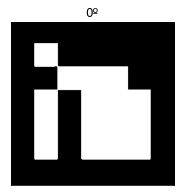

In [5]:
# Agora vamos ler o alvo
target0 = cv2.imread('alvo.jpg', 0)

# Binarizamos o alvo para facilitar o processamento
_, target0 = cv2.threshold(target0, 80, 255, cv2.THRESH_BINARY)

plt.figure(figsize = (3,3))
plt.imshow(target0, cmap='gray'); 
plt.title('0º')
plt.xticks([]); 
plt.yticks([])
plt.show()

([], [])

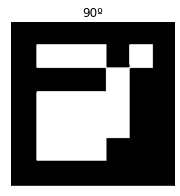

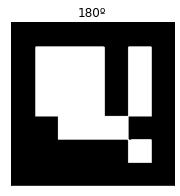

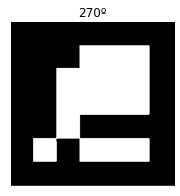

In [6]:
# Com o alvo em mãos, vamos achar as suas rotações de 90°
target90 = cv2.rotate(target0, cv2.ROTATE_90_CLOCKWISE) # 90°
target180 = cv2.rotate(target0, cv2.ROTATE_180) # 180°
target270 = cv2.rotate(target0, cv2.ROTATE_90_COUNTERCLOCKWISE) # 270°

plt.figure(figsize = (3,3))
plt.imshow(target90, cmap='gray')
plt.title('90º')
plt.xticks([]); 
plt.yticks([])
plt.figure(figsize = (3,3))
plt.imshow(target180, cmap='gray')
plt.title('180º')
plt.xticks([]); 
plt.yticks([])
plt.figure(figsize = (3,3))
plt.imshow(target270, cmap='gray')
plt.title('270º')
plt.xticks([]); 
plt.yticks([])

In [7]:
# Definimos coordenadas arbitrárias de forma a indetificar cada orientação
p1 = [-1, -1, 0]
p2 = [1, -1, 0]
p3 = [1, 1, 0]
p4 = [-1, 1, 0]

coords = []

coords.append(np.float32([p4, p1, p2, p3])) # 0°
coords.append(np.float32([p1, p2, p3, p4])) # 90°
coords.append(np.float32([p2, p3, p4, p1])) # 180°
coords.append(np.float32([p3, p4, p1, p2])) # 270°

# Criamos uma lista com os targets para facilitar
targets = []

targets.append(target0)
targets.append(target90)
targets.append(target180)
targets.append(target270)

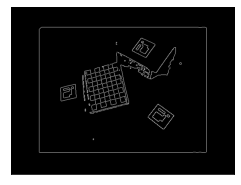

In [8]:
# Para efeito de visualização de como os frames serão tratador
# Vamos fazer cada passo com apenas 1 frame e plotar os resultados
# Queremos destacar os contornos para achar polígonos em seguida
def treat_color(frame):
    # Deixamos cada frame com tons de cinza
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Fazemos a binarização
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    # Extraímos as bordas
    frame = cv2.Canny(binary, 60, 100)
    # Encontra os contornos    
    contour, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return frame, contour, gray, binary

sample, contours, gray, binary = treat_color(frames[7])

plt.figure(figsize = (4,4))
plt.imshow(sample,cmap = 'gray')
plt.xticks([]); 
plt.yticks([])
plt.show()

In [9]:
# Com os contorno obtidos, seguimos para fazer a identificação de polígonos
def find_polygons(frame, contours):
    tetra = []
    # Criamos poligono com os contorno obtidos na função acima
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, 0.015*perimeter, True)
        if len(polygon) == 4 and cv2.isContourConvex(polygon):
            tetra.append(polygon)
    return tetra

tetra = find_polygons(sample, contours)
tetra

[array([[[419, 280]],
 
        [[391, 318]],
 
        [[437, 351]],
 
        [[465, 312]]], dtype=int32),
 array([[[183, 223]],
 
        [[142, 233]],
 
        [[143, 271]],
 
        [[186, 261]]], dtype=int32),
 array([[[340, 176]],
 
        [[340, 178]],
 
        [[342, 178]],
 
        [[342, 176]]], dtype=int32),
 array([[[324, 155]],
 
        [[324, 157]],
 
        [[326, 157]],
 
        [[326, 155]]], dtype=int32),
 array([[[373,  91]],
 
        [[346, 128]],
 
        [[386, 146]],
 
        [[411, 109]]], dtype=int32)]

In [10]:
# Agora vamos achar a matriz de homografia
def homography(tetras, frame):
    height, width = targets[0].shape
    corners = np.float32([[0,0], [0, height], [width, height], [width, 0]])
    poly = []
    direction = []
    for tetra in tetras:
        m_homography, _ = cv2.findHomography(np.float32(tetra), corners, cv2.RANSAC)
        result = cv2.warpPerspective(frame, m_homography, targets[0].shape)           
        min_error = 99999
        min_position = None

        # compara com as 4 orientações do alvo
        for i in range(0, len(targets)):
            curr = np.sum(np.abs(result - targets[i])) / (result.size)
            if curr < min_error:
                min_error = curr
                min_position = i                  

        # Define-se como 'match' os candidatos que obtiveram erro menor do que 20
        if min_error <20:
            poly.append(tetra)
            direction.append(min_position)
            
    return poly, direction

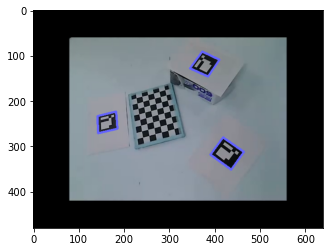

In [11]:
# Vamos testar a detecção  de alvos em um frame
poly, direction = homography(tetra, binary)
highlight = cv2.drawContours(frames[7], poly, -1, (100,100,255), 3)
plt.imshow(highlight)

In [12]:
# Enfim, vamos aplicar todos os passos feitos acima para todos os frames
poly = []
direction = [] 

for f in frames:
    sample, contours, gray, binary = treat_color(f)
    tetras = []
    tetras = find_polygons(f, contours)
   
    temp1, temp2 = homography(tetras, binary)
    
    poly.append(temp1)
    direction.append(temp2)


### 3. Obteção dos Parâmetros Extrínsecos

In [13]:
# A função que estima a pose da câmera recebe as coordenadas do alvo que indica sua direção
# Dependendo dessa direção, rotacionamos a matriz de destino
def find_pose(polygon, direction, coords, mat_int):
    if direction == 0:
        dst = coords[0]
    if direction == 1:
        dst = coords[1]
    if direction == 2:
        dst = coords[2]          
    if direction == 3:
        dst = coords[3] 
    # Calibramos a câmera com a matriz de  parâmetros intrínsecos obtida no começo do notebook  
    _, v_rotation, v_translation = cv2.solvePnP(dst, np.float32(polygon), mat_int, np.float32(distortion))
    # Gera a matriz de rotação pelo retorno da função solvePnP
    m_rotation, _ = cv2.Rodrigues(v_rotation)
    # Criamos uma matriz identidade
    m_id = np.identity(4)
    m_id[1, 1], m_id[2, 2] = -1, -1
    # A matriz abaixo guarda os locais de posicionamento dos objetos nas cenas
    m_pose = np.array([
        [rotacao[0][0], rotacao[0][1], rotacao[0][2], translation_vector[0]],
        [rotacao[1][0], rotacao[1][1], rotacao[1][2], translation_vector[1]],
        [rotacao[2][0], rotacao[2][1], rotacao[2][2], translation_vector[2]],
        [0.0, 0.0, 0.0, 1.0]
    ])
    
    m_pose = m_pose @ m_id
    
    m_pose = np.transpose(m_pose)
    
    return m_pose    

### 4. Renderização

In [14]:
# Renderizando o Pikachu
def get_pikachu():
    obj = OBJ('Pikachu.obj', swapyz=True)
    return obj

In [15]:
# Inicializando o OpenGL
def initOpenGL(dimensions):

    (width, height) = dimensions
    
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)

    glEnable(GL_DEPTH_TEST)

    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
 
    fovy = 2*np.arctan(0.5*480/mat_int[1,1]) * 180/np.pi
    aspect = (float)(640 * mat_int[1,1])/(480 * mat_int[0,0])
    gluPerspective(fovy, aspect, 0.1, 100.0)

In [16]:
# Criando o background
def background(img, dimensions):

    width, height = dimensions
    # Lendo a textura
    textureId = load_background_texture(img)
    glDepthMask(GL_FALSE)
    
    glMatrixMode(GL_PROJECTION)
    glPushMatrix()
    glLoadIdentity()
    gluOrtho2D(0, width, 0, height)
    
    # Habilitando a textura
    glEnable(GL_TEXTURE_2D)
    glBindTexture(GL_TEXTURE_2D, textureId)
    glMatrixMode(GL_MODELVIEW)
    glPushMatrix()

    glBegin(GL_QUADS)
    glTexCoord2f(0, 0); glVertex2f(0, 0)
    glTexCoord2f(1, 0); glVertex2f(width, 0)
    glTexCoord2f(1, 1); glVertex2f(width, height)
    glTexCoord2f(0, 1); glVertex2f(0, height)
    glEnd()
    
    glPopMatrix()
    glMatrixMode(GL_PROJECTION)
    glPopMatrix()
    glMatrixMode(GL_MODELVIEW)
    
    glBindTexture(GL_TEXTURE_2D, 0)
    glDepthMask(GL_TRUE)
    glFlush()  

In [17]:
def construct_cube(m):


SyntaxError: unexpected EOF while parsing (<ipython-input-17-ab46eab4cbbe>, line 1)

### 5. Referências